In [2]:
import pyodbc
import sys
import datetime

from Activo import *
from Accion import *
from Bono import *
from Derivado import *
from DerivadosTipos.DerivadosSCC import *
from DerivadosTipos.DerivadosFWD import *

from extraer_accion import *


from Cartera import *

In [3]:
server = '172.16.1.38'
username = 'sa'
password = 'qwerty123'
driver = '{ODBC Driver 17 for SQL Server}'
cn = pyodbc.connect('DRIVER=' + driver + ';SERVER=' + server + ';UID=' + username + ';PWD=' + password)

In [1]:
def cambiar_fecha(fecha):

    fechas = fecha.split("-")
    fechas = fechas[2].split(" ")[0] + "/" + fechas[1] + "/" + fechas[0]
    return fechas


In [4]:
def bonos_dbAlgebra(n,cn):
    bonos = "SELECT TOP(" + str(n) + ") bono.Moneda, bono.TablaDesarrollo, bono.Base1 , bono.Base2, bono.FechaEmision, riesgo.Riesgo AS RiesgoInt, bono.Nemotecnico AS Nemotecnico FROM [dbAlgebra].[dbo].[TdNemoRF] AS bono , [dbAlgebra].[dbo].[VwRiesgoRF] AS riesgo,  [dbPortFolio].[dbo].[TdPlanvitalCartera] AS planvital WHERE bono.Nemotecnico = riesgo.Nemotecnico AND bono.FechaEmision > '20190101' AND bono.Nemotecnico = planvital.Nemotecnico"
    bonos = pd.read_sql(bonos, cn)
    return pd.DataFrame(bonos)

def derivados_dBDerivados(cantidad, cn):

    derivados = "SELECT TOP ("+ str(cantidad) +") * FROM [dbDerivados].[dbo].[TdCarteraDerivados_V2] WHERE Tipo = 'SCC'"
    derivados = pd.read_sql(derivados, cn)

    derivado = pd.DataFrame()
    dev = []

    for i in range(cantidad):

        info_derivado = dict()
        info_derivado["Tipo"] = derivados["Tipo"][i]
        info_derivado["ID_Key"] = derivados["ID_Key"][i]
        info_derivado["Administradora"] = derivados["Administradora"][i]
        info_derivado["Fondo"] = derivados["Fondo"][i]
        info_derivado["Contraparte"] = derivados["Contraparte"][i]
        info_derivado["ID"] = int(derivados["ID"][i])
        info_derivado["Nemotecnico"] = derivados["Nemotecnico"][i]
        info_derivado["Mercado"] = derivados["Mercado"][i]     
        fecha = datetime.date(2019, 10, 14)
        hora = '1700'
        info_derivado["FechaEfectiva"] = cambiar_fecha(str(derivados["FechaEfectiva"][i]))
        info_derivado["FechaVenc"] = cambiar_fecha(str(derivados["FechaVenc"][i]))
        info_derivado["AjusteFeriados"] = derivados["AjusteFeriados"][i]
        info_derivado["NocionalActivo"] = derivados["NocionalActivo"][i]
        info_derivado["NocionalPasivo"] = derivados["NocionalActivo"][i]

        info_derivado["MonedaActivo"] = derivados["MonedaActivo"][i]
        info_derivado["MonedaPasivo"] = derivados["MonedaPasivo"][i]

        info_derivado["MonedaBase"] = derivados["MonedaBase"][i]
        info_derivado["TipoTasaActivo"] = derivados["TipoTasaActivo"][i]
        info_derivado["TipoTasaPasivo"] = derivados["TipoTasaPasivo"][i]
        info_derivado["TasaActivo"] = derivados["TasaActivo"][i]
        info_derivado["TasaPasivo"] = derivados["TasaPasivo"][i]
        info_derivado["FrecuenciaActivo"] = derivados["FrecuenciaActivo"][i]
        info_derivado["FrecuenciaPasivo"] = info_derivado["FrecuenciaActivo"]

        info1 = pd.DataFrame([info_derivado])

        tipo_derivado = derivados["Tipo"][i]
        
        if tipo_derivado == 'SCC':

            derivado_info = DerivadosSCC(fecha, hora, info1, cn)
        
        elif tipo_derivado == 'FWD':

            derivado_info = DerivadosFWD(fecha, hora, info1, cn)


        dev.append(derivado_info)

    derivado["Derivado"] = dev
    derivado["Nemotecnico"] = 'BCINO UF 200709_A'
    return derivado

In [5]:
def conversionSYP(riesgo):
    return {1: 'AAA',2: 'AA',3: 'AA',4: 'AA',5: 'A',6: 'A',7: 'A',8: 'BBB',9: 'BBB',10: 'BBB',\
            11: 'BB',12: 'BB',13: 'BB',14: 'B',15: 'B',16: 'B',17: 'CCC',18: 'CC',19: 'CC',20: 'C',\
            21: 'C',22: 'C',23: 'D',24: 'E'}.get(riesgo)

def ajustes(bonos):
    bonos['FechaEmision'] = bonos['FechaEmision'].apply(lambda x: x.strftime('%Y-%m-%d'))
    bonos['Base1'] = bonos['Base1'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Base2'] = bonos['Base2'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Convencion'] = bonos['Base1'].apply(lambda x: str(x)) + '/' + bonos['Base2'].apply(lambda x: str(x))
    bonos['Riesgo'] = bonos['RiesgoInt'].apply(lambda x: conversionSYP(x))
    return bonos

In [6]:
#bonos = ajustes(bonos_dbAlgebra(1,cn))
#bonos

In [7]:
derivados = derivados_dBDerivados(5, cn)
derivados["Derivado"][0].genera_flujos()
derivados["Derivado"][0].valoriza_flujos()
derivados["Derivado"][0].flujos_valorizados[["ID","ActivoPasivo", "Fecha", "FechaFixing", "FechaFlujo", "FechaPago", "Flujo", "ValorPresenteMonFlujo", "Moneda", "MonedaBase"]]

,ID,ActivoPasivo,Fecha,FechaFixing,FechaFlujo,FechaPago,Flujo,ValorPresenteMonFlujo,Moneda,MonedaBase
0,1368,-1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,4.331011e+07,4.293818e+07,CLP,CLP
1,1368,-1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.549401e+07,3.494116e+07,CLP,CLP
2,1368,-1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,4.784481e+07,4.665317e+07,CLP,CLP
3,1368,-1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.042244e+09,4.875468e+09,CLP,CLP
4,1368,1,2019-10-14,2020-05-12,2020-05-12,2020-05-12,3.652233e+07,3.620869e+07,CLP,CLP
5,1368,1,2019-10-14,2020-11-12,2020-11-12,2020-11-12,3.692515e+07,3.635001e+07,CLP,CLP
6,1368,1,2019-10-14,2021-05-12,2021-05-12,2021-05-12,3.632093e+07,3.541630e+07,CLP,CLP
7,1368,1,2019-10-14,2021-11-12,2021-11-12,2021-11-12,5.036925e+09,4.870324e+09,CLP,CLP


In [8]:
arreglo_acciones = ["AESGENER", "AGUAS-A", "ANDINA-A", "ANDINA-B", "DE000DWS2D90", "ANTARCHILE"]
arreglo_fondos = ["A", "A", "A", "A", "A", "A"]


acciones = historico(arreglo_acciones, arreglo_fondos, 60)
acciones


,Moneda,Nombre,Nemotecnico,Inversion,Historico
0,CLP,AESGENER,AESGENER,1.748148e+09,"[[0, 0.0025957870479299534, -0.007433469137058..."
1,CLP,AGUAS-A,AGUAS-A,1.595594e+07,"[[0, 0.003305297208302039, 0.03566773260328181..."
2,CLP,ANDINA-A,ANDINA-A,1.492768e+08,"[[0, 0.00034804011961498776, 0.018505998119275..."
3,CLP,ANDINA-B,ANDINA-B,1.106585e+09,"[[0, 0.005746838657845234, 0.0175731917247771,..."
4,CLP,DE000DWS2D90,DE000DWS2D90,1.253353e+10,"[[0, -0.011984448831005957, -0.025391621016988..."
5,CLP,ANTARCHILE,ANTARCHILE,1.567905e+08,"[[0, 0.009876696995043567, 0.00310408270978682..."


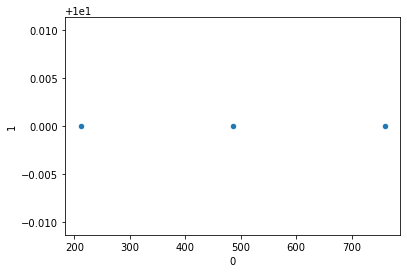

In [16]:
cartera = Cartera(acciones, pd.DataFrame(), derivados, "CLP", datetime.date(2019, 10, 14), cn)

In [9]:
print(cartera.get_historicos_totales())

NameError: name 'cartera' is not defined

In [ ]:
print(cartera.get_retornos_totales())

In [ ]:
cartera.set_volatilidad_cartera()
print(cartera.get_volatilidad_cartera())

In [17]:
cartera.get_covarianza()

,0,1,2,3,4,5,6,7,8
0,8.482153e-07,8.759157e-07,0.000001,-0.000002,0.000002,0.000005,-0.000004,0.000002,0.000003
1,8.759157e-07,1.021051e-06,0.000001,-0.000002,0.000002,0.000007,-0.000003,0.000002,0.000003
2,1.051303e-06,1.271303e-06,0.000002,-0.000003,0.000002,0.000007,-0.000003,0.000002,0.000004
3,-2.088455e-06,-1.879414e-06,-0.000003,0.000181,-0.000012,0.000015,-0.000003,-0.000006,-0.000049
4,2.171161e-06,2.097422e-06,0.000002,-0.000012,0.000100,0.000039,0.000058,0.000016,0.000037
5,5.058102e-06,6.798106e-06,0.000007,0.000015,0.000039,0.000418,0.000084,0.000051,0.000085
6,-3.668869e-06,-3.284773e-06,-0.000003,-0.000003,0.000058,0.000084,0.000433,0.000008,0.000084
7,2.440851e-06,2.350349e-06,0.000002,-0.000006,0.000016,0.000051,0.000008,0.000063,0.000009
8,3.028277e-06,2.725864e-06,0.000004,-0.000049,0.000037,0.000085,0.000084,0.000009,0.000152


In [18]:
cartera.get_correlacion()

,CLP#209,CLP#479,CLP#750,AESGENER,AGUAS-A,ANDINA-A,ANDINA-B,DE000DWS2D90,ANTARCHILE
CLP#209,1.000000,0.941208,0.873728,-0.168623,0.235814,0.268670,-0.191458,0.333100,0.266914
CLP#479,0.941208,1.000000,0.963002,-0.138307,0.207632,0.329116,-0.156234,0.292345,0.218982
CLP#750,0.873728,0.963002,1.000000,-0.195195,0.115511,0.270598,-0.103093,0.236295,0.223564
AESGENER,-0.168623,-0.138307,-0.195195,1.000000,-0.088274,0.056380,-0.010407,-0.060160,-0.293936
AGUAS-A,0.235814,0.207632,0.115511,-0.088274,1.000000,0.188988,0.277994,0.195585,0.303122
ANDINA-A,0.268670,0.329116,0.270598,0.056380,0.188988,1.000000,0.197562,0.311225,0.338087
ANDINA-B,-0.191458,-0.156234,-0.103093,-0.010407,0.277994,0.197562,1.000000,0.049990,0.327175
DE000DWS2D90,0.333100,0.292345,0.236295,-0.060160,0.195585,0.311225,0.049990,1.000000,0.093734
ANTARCHILE,0.266914,0.218982,0.223564,-0.293936,0.303122,0.338087,0.327175,0.093734,1.000000


In [ ]:
cartera.get_volatilidad_niveles()